#PyTorch for Deep Learning: Zero to Mastery course
## This is my first Pytorch coding:
###03_pytorch_computer_vision exercise
[see: https://github.com/mrdbourke/pytorch-deep-learning
](https://https://github.com/mrdbourke/pytorch-deep-learning)

###Import Necessary Libraries

In [2]:
import torch, torchvision, random
import torch.nn as nn
from torchvision import datasets
import matplotlib.pyplot as plt
!pip install torchmetrics
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 10.3 MB/s eta 0:00:00


###Agnostic Device

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

###Loading the data
MNIST

In [3]:
traindata = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor())
testdata = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 169952055.51it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 96908555.06it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 174002198.88it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 12011682.70it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



###Visualizing Samples

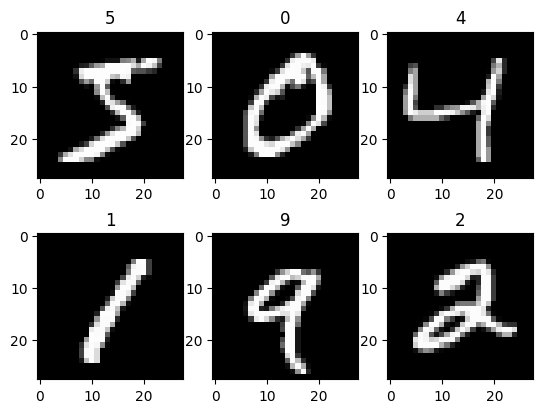

In [5]:
for i in range(6):

  image, label = traindata[i]
  plt.subplot(2,3,1+i)
  plt.imshow(image.squeeze(),cmap="gray")
  plt.title(label);

###Using Data Loader From Pytorch

In [6]:
train_data=torch.utils.data.DataLoader(traindata,batch_size=32, shuffle=True)
test_data=torch.utils.data.DataLoader(testdata, batch_size=32,shuffle=False)

###Recreating Tiny VGG CNN Model
[https://poloclub.github.io/cnn-explainer/](https://https://poloclub.github.io/cnn-explainer/)

In [7]:
class tinyvgg(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1=nn.Sequential(
        nn.Conv2d(
                  in_channels=1,
                  out_channels=8,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(
                  in_channels=8,
                  out_channels=8,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

    self.layer2=nn.Sequential(
        nn.Conv2d(
                  in_channels=8,
                  out_channels=8,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(
                  in_channels=8,
                  out_channels=8,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=2*14*14,
                  out_features=10))


  def forward(self,x):
    x=self.layer1(x)
    x=self.layer2(x)

    x=self.classifier(x)

    return x



### Setting Up Loss Function, Optimizer And Accuracy

In [16]:
model=tinyvgg().to(device)
loss_fn=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model.parameters(),lr=0.1)
accuracy= MulticlassAccuracy(num_classes=10).to(device)

###Train The Model

In [17]:
epochs=3
train_acc=0
train_loss=0
test_loss=0
test_acc=0
for epoch in range(epochs):
  for batch, (train_features, train_labels) in enumerate(train_data):
    train_features, train_labels = train_features.to(device), train_labels.to(device)
    model.train()
    pred=model(train_features)
    loss=loss_fn(pred,train_labels)
    train_loss+=loss
    train_acc+=accuracy(pred.argmax(dim=1),train_labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  model.eval()
  with torch.inference_mode():
    for batch, (train_features, train_labels) in enumerate(train_data):
      train_features, train_labels = train_features.to(device), train_labels.to(device)
      test_pred=model(train_features)
      test_loss+=loss_fn(test_pred,train_labels)
      test_acc+=accuracy(test_pred.argmax(dim=1),train_labels)


    train_acc/=len(train_data)
    train_loss/=len(train_data)
    test_acc/=len(train_data)
    test_loss/=len(train_data)
  print(f"Epoch:{epoch} | Train Accuracy: {train_acc} | Train Loss: {train_loss} | Test Accuracy: {test_acc} | Test Loss: {test_loss}")



Epoch:0 | Train Accuracy: 0.8945895433425903 | Train Loss: 0.29619359970092773 | Test Accuracy: 0.9703364372253418 | Test Loss: 0.0853835791349411
Epoch:1 | Train Accuracy: 0.972248375415802 | Train Loss: 0.08105771243572235 | Test Accuracy: 0.9785366058349609 | Test Loss: 0.06247207894921303
Epoch:2 | Train Accuracy: 0.9791523814201355 | Train Loss: 0.0635460913181305 | Test Accuracy: 0.9795328378677368 | Test Loss: 0.05751810222864151


###Making Predictions Using Trained Model And Visualize, Comparing The Prediciton To The Target Label.

In [18]:
predict=[]
label=[]
X=[]
model.eval()

with torch.inference_mode():
  for i , (x, y) in enumerate(testdata):
    logits=model(torch.unsqueeze(x.to(device), dim=1))
    predictions=torch.softmax(logits,dim=1).argmax(dim=1)
    predict.append(predictions)
    label.append(y)
    X.append(x)

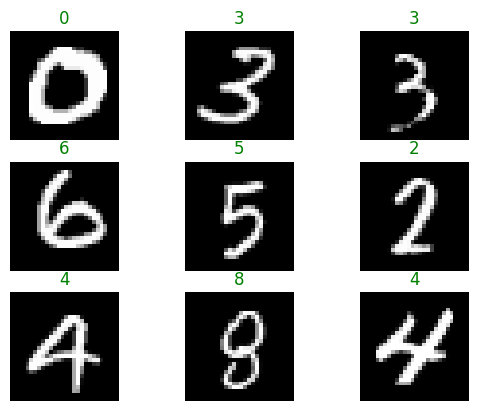

In [19]:
import random
for i in range(9):
  b=random.randint(0,len(predict))
  plt.subplot(3,3,i+1)
  plt.imshow(X[b].squeeze(),cmap="gray")
  if label[b] == label[b]:
    plt.title(label[b],c="g")
  else:
    plt.title(predict[b],c="r")
  plt.axis(False)

###Plot A Confusion Matrix Comparing Model's Predictions To The Truth Labels.

(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

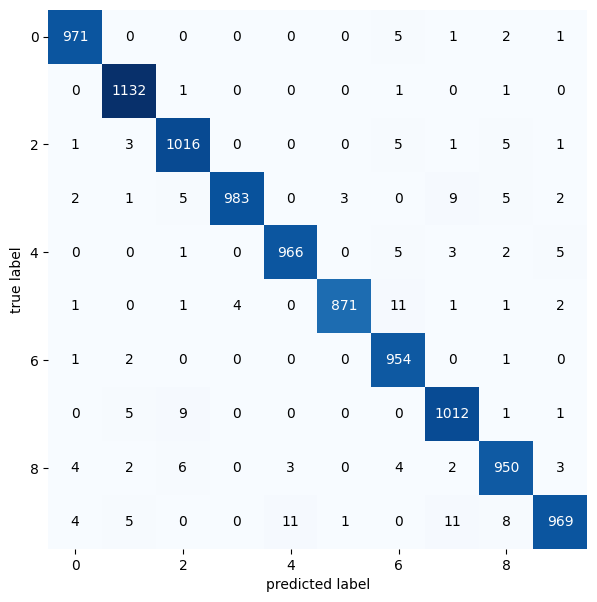

In [21]:
conf=ConfusionMatrix(task="Multiclass",num_classes=10)
matrix= conf(torch.cat(predict).to("cpu"), testdata.targets.to("cpu"))
plot_confusion_matrix(matrix.numpy(),10,figsize=(10, 7))